## Importing Libraries

In [38]:
!python -m pip install transformers
!python -m pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')
np.__version__

'1.22.4'

## Loading the data

In [3]:
!gdown 1EgJ4xUZeNzzCMjRe4Y5c1rTsmhWLD8lL

Downloading...
From: https://drive.google.com/uc?id=1EgJ4xUZeNzzCMjRe4Y5c1rTsmhWLD8lL
To: /content/Symptom2DiseaseID.csv
100% 240k/240k [00:00<00:00, 103MB/s]


In [4]:
df = pd.read_csv('./Symptom2DiseaseID.csv', delimiter=';')
df.head()

,indeks,label,text
0,0,Psoriasis,"Saya telah mengalami ruam kulit di lengan, ka..."
1,1,Psoriasis,"Kulit saya mengelupas, terutama di lutut, sik..."
2,2,Psoriasis,"Saya telah mengalami nyeri sendi di jari, per..."
3,3,Psoriasis,"Ada debu seperti perak di kulit saya, terutam..."
4,4,Psoriasis,Kuku saya memiliki penyok atau lubang kecil d...


In [5]:
df.drop("indeks", axis=1, inplace=True)

In [6]:
import itertools

for i in range(len(df["text"])):
    df["text"][i] = re.sub('  +', ' ', df["text"][i])
    df["text"][i] = ''.join(''.join(s)[:1] for _, s in itertools.groupby(df["text"][i]))
    df["text"][i] = df["text"][i].lower()
    df["label"][i] = df["label"][i].lower()

df.label = df.label.str.replace('^ +| +$', '', regex=True)

In [7]:
for nama_kolom in df.columns:
  print(df[nama_kolom].value_counts(), "\n")

psoriasis                          50
pembuluh mekar                     50
penyakit ulkus peptikum            50
reaksi obat                        50
penyakit refluks gastroesofagus    50
alergi                             50
infeksi saluran kemih              50
malaria                            50
penyakit kuning                    50
spondylosis serviks                50
migrain                            50
hipertensi                         50
asma bronkial                      50
jerawat                            50
radang sendi                       50
wasir dimorfik                     50
radang paru-paru                   50
flu biasa                          50
infeksi jamur                      50
demam berdarah                     50
impetigo                           50
cacar air                          50
penyakit tipus                     50
diabetes                           50
Name: label, dtype: int64 

 saya merasa sangat gatal, sakit, dan lelah. selain itu, ber

Creating encodings for disease.

In [8]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'psoriasis',
  1: 'pembuluh mekar',
  2: 'penyakit tipus',
  3: 'cacar air',
  4: 'impetigo',
  5: 'demam berdarah',
  6: 'infeksi jamur',
  7: 'flu biasa',
  8: 'radang paru-paru',
  9: 'wasir dimorfik',
  10: 'radang sendi',
  11: 'jerawat',
  12: 'asma bronkial',
  13: 'hipertensi',
  14: 'migrain',
  15: 'spondylosis serviks',
  16: 'penyakit kuning',
  17: 'malaria',
  18: 'infeksi saluran kemih',
  19: 'alergi',
  20: 'penyakit refluks gastroesofagus',
  21: 'reaksi obat',
  22: 'penyakit ulkus peptikum',
  23: 'diabetes'},
 {'psoriasis': 0,
  'pembuluh mekar': 1,
  'penyakit tipus': 2,
  'cacar air': 3,
  'impetigo': 4,
  'demam berdarah': 5,
  'infeksi jamur': 6,
  'flu biasa': 7,
  'radang paru-paru': 8,
  'wasir dimorfik': 9,
  'radang sendi': 10,
  'jerawat': 11,
  'asma bronkial': 12,
  'hipertensi': 13,
  'migrain': 14,
  'spondylosis serviks': 15,
  'penyakit kuning': 16,
  'malaria': 17,
  'infeksi saluran kemih': 18,
  'alergi': 19,
  'penyakit refluks gastroesofag

## Data Distribution

Text(0.5, 1.0, 'Count of each disease')

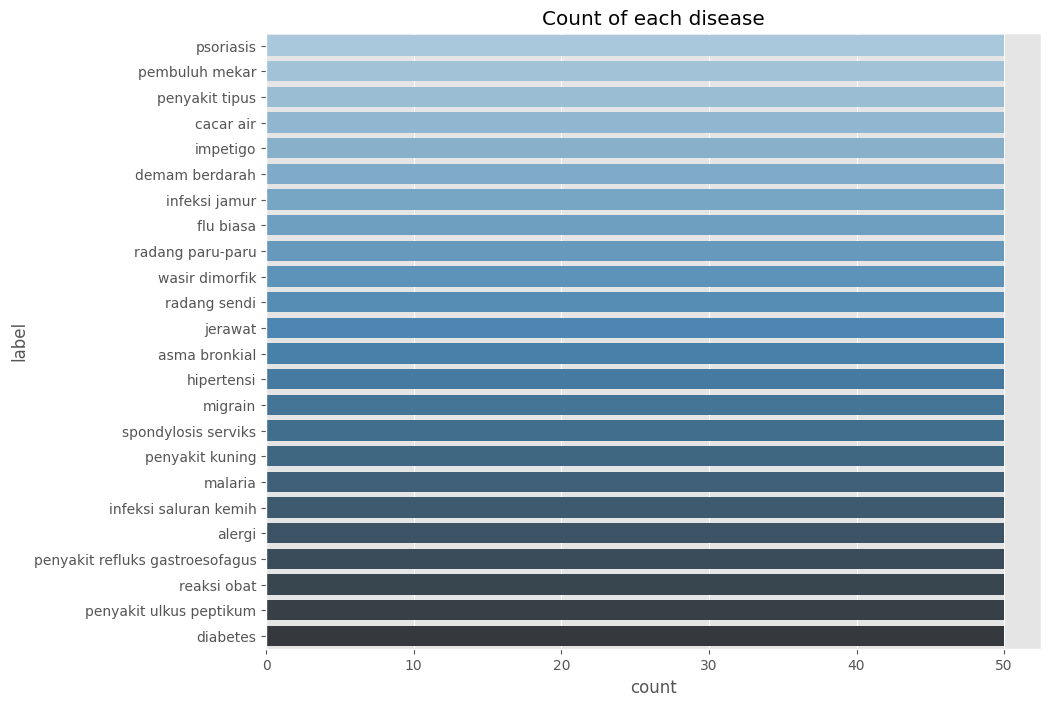

In [9]:
plt.figure(figsize = (10, 8))

sea.countplot(y = df['label'], palette = 'Blues_d')
plt.title('Count of each disease')

## Distribution of the lenght of description

  0%|          | 0/1200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of description length')

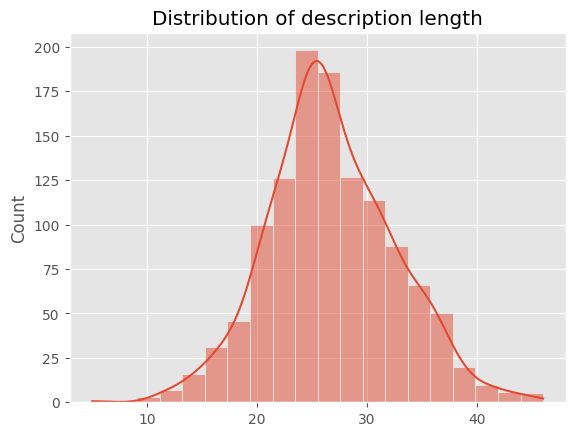

In [10]:
length = []
for txt in tqdm(df['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')

In [11]:
df['label'] = df['label'].map(lambda x : label2int[x])

In [12]:
df["label"].value_counts()

0     50
1     50
22    50
21    50
20    50
19    50
18    50
17    50
16    50
15    50
14    50
13    50
12    50
11    50
10    50
9     50
8     50
7     50
6     50
5     50
4     50
3     50
2     50
23    50
Name: label, dtype: int64

In [13]:
X, y = df['text'].values, df['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 1749


## Creating the train and testing data

In [14]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((1080,), (120,), (1080,), (120,))

## Converting the data into `tf.data.Dataset`

1. The tokenizer of pretrained bert is downloaded and used.
2. `train_dataset` and `val_dataset` is created using `tf.data.Dataset` with batch size 8.

In [15]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


In [52]:
num_classes = 24

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    num_labels = num_classes, 
    id2label = int2label, 
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7f9896f5f8b0> True
<keras.layers.regularization.dropout.Dropout object at 0x7f9897002f20> True
<keras.layers.core.dense.Dense object at 0x7f989730f760> True


In [54]:
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_262 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  18456     
                                                                 
Total params: 177,871,896
Trainable params: 177,871,896
Non-trainable params: 0
_________________________________________________________________


In [55]:
EPOCHS = 10
batch_size = 16

history = model.fit(train_dataset,
          batch_size=batch_size,
          epochs = EPOCHS,
          validation_data = val_dataset)

Epoch 1/10
135/135 [==============================] - 183s 1000ms/step - loss: 3.1083 - accuracy: 0.1093 - val_loss: 2.5042 - val_accuracy: 0.4583
Epoch 2/10
135/135 [==============================] - 131s 972ms/step - loss: 1.7928 - accuracy: 0.6694 - val_loss: 1.0285 - val_accuracy: 0.7750
Epoch 3/10
135/135 [==============================] - 131s 971ms/step - loss: 0.7332 - accuracy: 0.9046 - val_loss: 0.4863 - val_accuracy: 0.9083
Epoch 4/10
135/135 [==============================] - 131s 972ms/step - loss: 0.3077 - accuracy: 0.9685 - val_loss: 0.2442 - val_accuracy: 0.9583
Epoch 5/10
135/135 [==============================] - 131s 973ms/step - loss: 0.1458 - accuracy: 0.9926 - val_loss: 0.2346 - val_accuracy: 0.9417
Epoch 6/10
135/135 [==============================] - 132s 975ms/step - loss: 0.1068 - accuracy: 0.9944 - val_loss: 0.1855 - val_accuracy: 0.9500
Epoch 7/10
135/135 [==============================] - 131s 972ms/step - loss: 0.0675 - accuracy: 0.9972 - val_loss: 0.1339 

In [56]:
model.evaluate(val_dataset, batch_size=batch_size)

15/15 [==============================] - 5s 336ms/step - loss: 0.0899 - accuracy: 0.9750


[0.08990022540092468, 0.9750000238418579]

## Plotting the loss and accuracy plot.

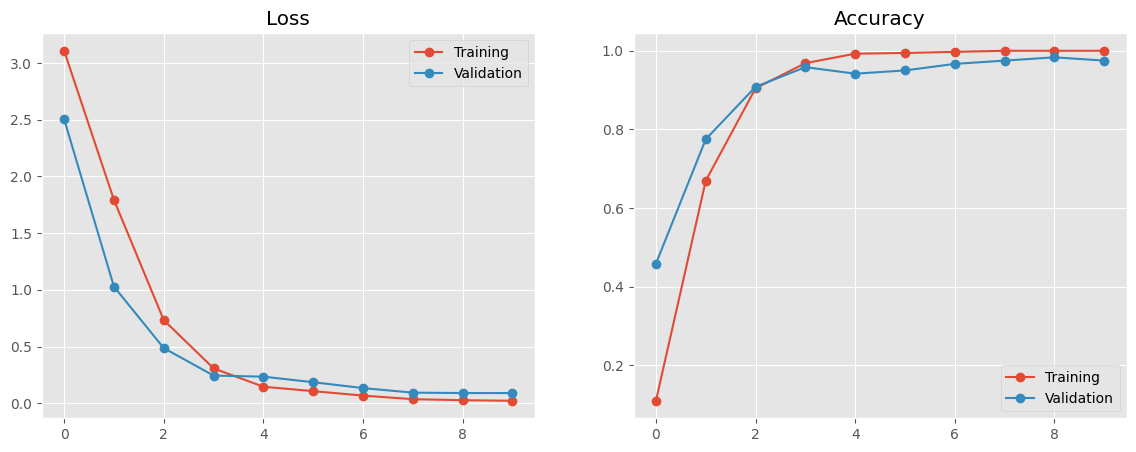

In [57]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

## Testing the model on custom input.

In [62]:
path = "./model_bert_multilungual_v2"
path2 = "./tokenizer_bert_multilungual_v2"
model.save_pretrained(path)
tokenizer.save_pretrained(path2)

('./tokenizer_bert_multilungual_v2/tokenizer_config.json',
 './tokenizer_bert_multilungual_v2/special_tokens_map.json',
 './tokenizer_bert_multilungual_v2/vocab.txt',
 './tokenizer_bert_multilungual_v2/added_tokens.json',
 './tokenizer_bert_multilungual_v2/tokenizer.json')

In [63]:
!zip -r model_bert_multilungual_v2.zip "/content/model_bert_multilungual_v2"

  adding: content/model_bert_multilungual_v2/ (stored 0%)
  adding: content/model_bert_multilungual_v2/tf_model.h5 (deflated 7%)
  adding: content/model_bert_multilungual_v2/config.json (deflated 60%)


In [64]:
!zip -r tokenizer_bert_multilungual_v2.zip "/content/tokenizer_bert_multilungual_v2"

  adding: content/tokenizer_bert_multilungual_v2/ (stored 0%)
  adding: content/tokenizer_bert_multilungual_v2/special_tokens_map.json (deflated 42%)
  adding: content/tokenizer_bert_multilungual_v2/tokenizer_config.json (deflated 42%)
  adding: content/tokenizer_bert_multilungual_v2/vocab.txt (deflated 45%)
  adding: content/tokenizer_bert_multilungual_v2/tokenizer.json (deflated 67%)


In [65]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

In [66]:
tokenizerlocal = BertTokenizer.from_pretrained("./tokenizer_bert_multilungual_v2", local_files_only=True)

In [67]:
modellocal = BertForSequenceClassification.from_pretrained("./model_bert_multilungual_v2", from_tf=True)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [68]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=modellocal, tokenizer=tokenizerlocal, top_k = 24)

text1 = str(" Penglihatan saya berkabut, dan tampaknya semakin memburuk. Saya merasa lelah dan lelah sepanjang waktu. Saya juga sering mengalami pusing parah dan pusing.").lower()
text2 = str("Saya mengalami sembelit dan sakit perut, dan itu sangat tidak nyaman. Sakit perut semakin parah dan mulai mempengaruhi kehidupan sehari-hari saya. Apalagi setiap malam saya menggigil, diikuti demam ringan.").lower()

pred1 = pipe(text1)
pred2 = pipe(text2)

print(pred1[0][:2])
print(pred2[0][:2])

[{'label': 'diabetes', 'score': 0.9831070899963379}, {'label': 'alergi', 'score': 0.0030360929667949677}]
[{'label': 'penyakit tipus', 'score': 0.9881128668785095}, {'label': 'penyakit ulkus peptikum', 'score': 0.0012035921681672335}]


In [69]:
!ls -lh tokenizer_bert_multilungual_v2.zip model_bert_multilungual_v2.zip

-rw-r--r-- 1 root root 630M May 30 12:44 model_bert_multilungual_v2.zip
-rw-r--r-- 1 root root 1.5M May 30 12:45 tokenizer_bert_multilungual_v2.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [71]:
!cp -r tokenizer_bert_multilungual_v2.zip "/content/drive/My Drive/Save Model Capstone/"

In [72]:
!cp -r model_bert_multilungual_v2.zip "/content/drive/My Drive/Save Model Capstone/"